In [ ]:
# 필수 라이브러리 설치
!pip install torch torchvision opencv-python matplotlib ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 35.5 MB/s eta 0:00:00



0: 736x1280 1 frame, 2 red balls, 1 table, 1 white ball, 2 yellow balls, 1614.8ms
Speed: 13.2ms preprocess, 1614.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


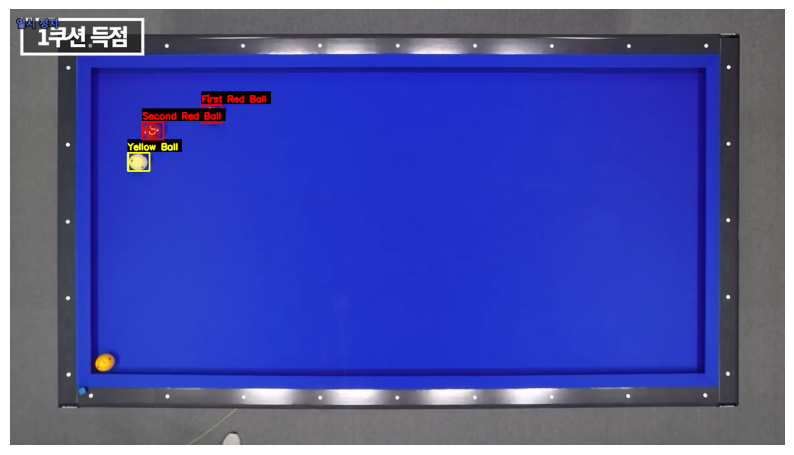

In [ ]:
# 라이브러리 import
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 모델 로드
model_path = "/content/drive/MyDrive/AIFFEL/Aiffelthon/ModelTest/best_pt_January_3rd_Jihye.pt"
model = YOLO(model_path)  # YOLO 모델 로드

# 공 탐지 및 보정 함수
def process_detections(results):
    detections = results[0].boxes.data.cpu().numpy()  # 탐지 결과 (좌표, 신뢰도, 클래스 ID)
    ball_positions = {"white_ball": None, "yellow_ball": None, "red_balls": []}

    for detection in detections:
        x1, y1, x2, y2, conf, class_id = detection
        label = results[0].names[int(class_id)]

        if label == "yellow ball":
            cropped_ball = image[int(y1):int(y2), int(x1):int(x2)]
            if check_white_ball(cropped_ball):
                label = "white ball"

        if label == "white ball":
            ball_positions["white_ball"] = [x1, y1, x2, y2]
        elif label == "yellow ball":
            ball_positions["yellow_ball"] = [x1, y1, x2, y2]
        elif label == "red ball":
            ball_positions["red_balls"].append([x1, y1, x2, y2, conf])

    if len(ball_positions["red_balls"]) == 2:
        ball_positions["red_balls"].sort(key=lambda ball: ball[4], reverse=True)
        ball_positions["first_objective"] = ball_positions["red_balls"][0]
        ball_positions["second_objective"] = ball_positions["red_balls"][1]

    return ball_positions

# 흰 공 여부 확인 함수
def check_white_ball(cropped_ball):
    hsv_ball = cv2.cvtColor(cropped_ball, cv2.COLOR_BGR2HSV)
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 25, 255])
    mask = cv2.inRange(hsv_ball, lower_white, upper_white)
    white_pixels = cv2.countNonZero(mask)
    return white_pixels / mask.size > 0.7  # 흰색 비율 70% 이상이면 흰 공으로 판단

# 시각화 함수 (텍스트 배경 및 위치 조정)
def visualize_detections(image, ball_positions):
    if ball_positions["white_ball"]:
        x1, y1, x2, y2 = map(int, ball_positions["white_ball"])
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255, 255), 2)
        text = "White Ball"
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        cv2.rectangle(image, (x1, y1 - text_size[1] - 10), (x1 + text_size[0] + 5, y1 - 2), (0, 0, 0), -1)
        cv2.putText(image, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    if ball_positions["yellow_ball"]:
        x1, y1, x2, y2 = map(int, ball_positions["yellow_ball"])
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 255), 2)
        text = "Yellow Ball"
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        cv2.rectangle(image, (x1, y1 - text_size[1] - 10), (x1 + text_size[0] + 5, y1 - 2), (0, 0, 0), -1)
        cv2.putText(image, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

    for idx, red_ball in enumerate(ball_positions["red_balls"]):
        x1, y1, x2, y2, conf = map(int, red_ball)
        label = "First Red Ball" if idx == 0 else "Second Red Ball"
        text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        cv2.rectangle(image, (x1, y1 - text_size[1] - 10), (x1 + text_size[0] + 5, y1 - 2), (0, 0, 0), -1)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 이미지 경로 설정 및 실행
image_path = "/content/drive/MyDrive/AIFFEL/Aiffelthon/ModelTest/onlyball1.png"
image = cv2.imread(image_path)  # 이미지 로드
results = model(image)  # 모델 추론

# 탐지된 공 보정 및 시각화
ball_positions = process_detections(results)
visualize_detections(image, ball_positions)  # 시각화
